In [1]:
import pandas as pd

import utils
import visualization


# Prepare the input

- Read EC and coordinate all the available sites from Ameriflux, Fluxnet and ICOS networks


In [2]:
data_path = "../data/"
df, megerd_coords = utils.read_data(data_path)


### Selecting sites and calculating maximum LUE

- They should have at least two years of data
- Sort descending based on LUE
- Take the median of the top 10% of the sorted data for maximum LUE
- Divide the EBF to tropics and temprate
- Drop biomes with less than three sites in them


In [3]:
df, site_annual_max_lue, site_annual_max_lue_se = utils.calculate_max_lue(
    df, megerd_coords
)

### **Table 1: Stats**


In [4]:
types = site_annual_max_lue["type"].unique()
names = site_annual_max_lue["name"].unique()

counts_df = pd.DataFrame(columns=["type", "sites", "days"])
for type in types:
    site_count = len(site_annual_max_lue[site_annual_max_lue["type"] == type])
    days = len(df[df["new_type"] == type])
    counts_df.loc[len(counts_df)] = [type, site_count, days]
print("Total number of sites and days:\n")
print(counts_df[["sites", "days"]].sum())
print("\nNumber of sites and days for each type:")
counts_df

Total number of sites and days:

sites       320
days     312024
dtype: int64

Number of sites and days for each type:


,type,sites,days
0,DBF,43,43629
1,mid_EBF,8,10898
2,GRA,57,51284
3,CRO,39,40630
4,MF,12,10143
5,WET,34,25751
6,ENF,73,66894
7,OSH,25,25016
8,WSA,9,18751
9,SAV,10,12173


Save the site maximum LUE to CSV


In [5]:
site_annual_max_lue.to_csv("../outputs/site_annual_max_lue.csv", index=False)

### **Figure 1: Distribution of EC sites**


/home/hamid/dscovr/EL_LUE_Codes/src/visualization.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


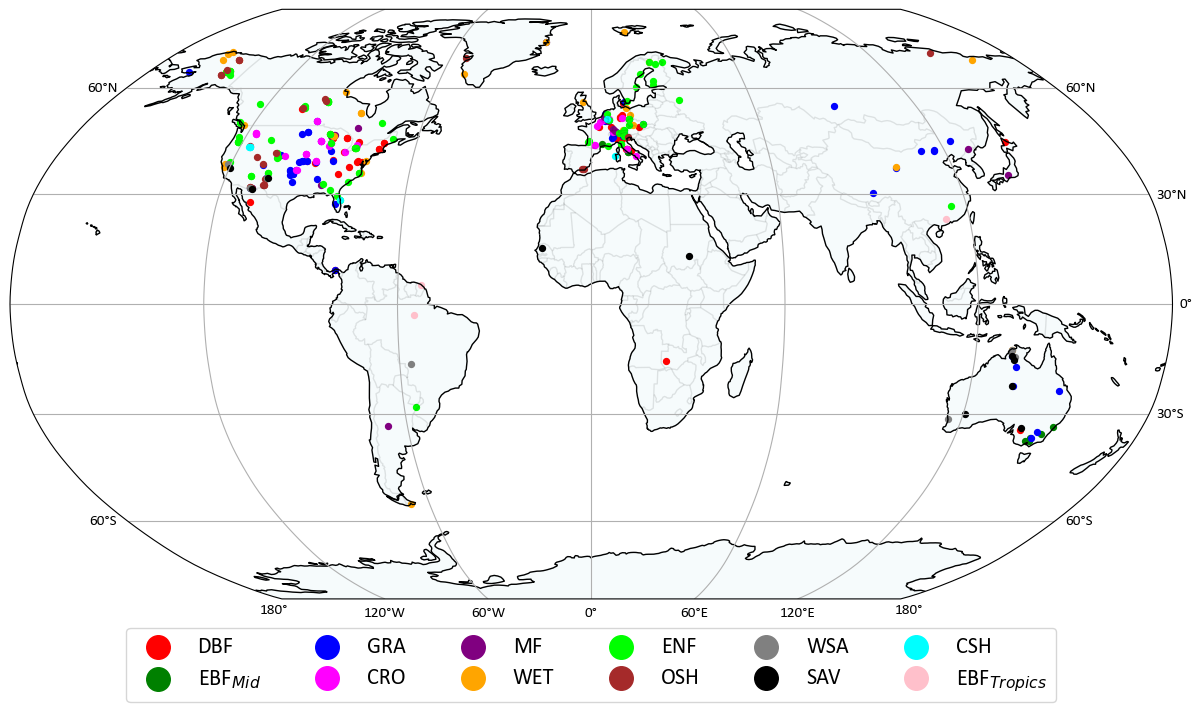

Figure 1: The distribution of EC sites used is saved as annual_max_lue_map.png in outputs folder.


In [6]:
visualization.plot_ec_sites(site_annual_max_lue, types)

### **Caclualte biome level maximum LUE based on median**


In [7]:
biome_LUEMax_median, biome_LUEMax_std, biome_LUEMax_se = utils.calculate_biome_LUEMax(
    site_annual_max_lue
)

Biome level maximum LUE is saved as biome_LUEMax_median.csv and biome_LUEMax_std.csv in outputs folder.


### **Plotting the biome LUE max, LAI, NIRv, NIRvN**


First extract the data


In [8]:
(
    lue,
    lue_std,
    nirv_std,
    nirv,
    glass_lai,
    glass_lai_std,
    modis_lai,
    modis_lai_std,
    norm_nirv_glass,
    norm_nirv_glass_std,
    norm_nirv_modis,
    norm_nirv_modis_std,
    # No crop biome
    lue_no_cro,
    lue_std_no_cro,
    nirv_std_no_CRO,
    nirv_no_CRO,
    glass_lai_no_cro,
    glass_lai_std_no_cro,
    modis_lai_no_cro,
    modis_lai_std_no_cro,
    norm_nirv_glass_no_cro,
    norm_nirv_glass_std_no_cro,
    norm_nirv_modis_no_cro,
    norm_nirv_modis_std_no_cro,
    biome_LUEMax_median_no_CRO,
    biome_LUEMax_std_no_CRO,
) = utils.extract_biome_data(biome_LUEMax_median, biome_LUEMax_std)

Get the number of measurements for each type, including crop type and not including crop type, for linear regression. This is needed for the weight calculations


In [9]:
types = biome_LUEMax_median.index
types_no_CRO = biome_LUEMax_median_no_CRO.index
num_measurements = site_annual_max_lue["type"].value_counts()
num_measurements = num_measurements.reindex(types, fill_value=0).values
num_measurements_no_cro = site_annual_max_lue[site_annual_max_lue["type"] != "CRO"][
    "type"
].value_counts()
num_measurements_no_cro = num_measurements_no_cro.reindex(
    types_no_CRO, fill_value=0
).values


## **Figure 2: Variables boxplot**


/home/hamid/dscovr/EL_LUE_Codes/src/visualization.py:663: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/hamid/dscovr/EL_LUE_Codes/src/visualization.py:663: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/hamid/dscovr/EL_LUE_Codes/src/visualization.py:663: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/home/hamid/dscovr/EL_LUE_Codes/src/visualization.py:663: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


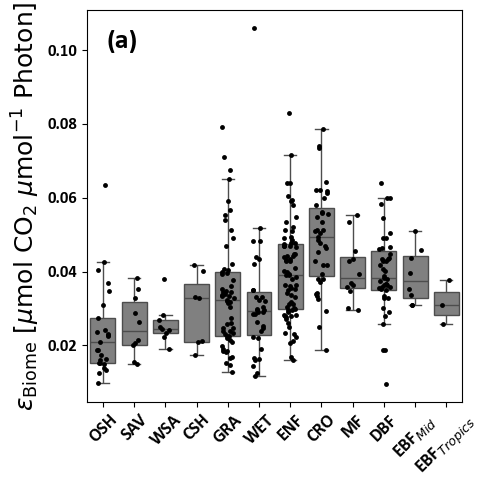

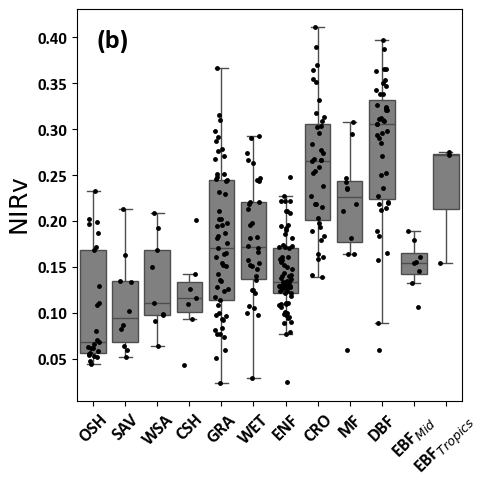

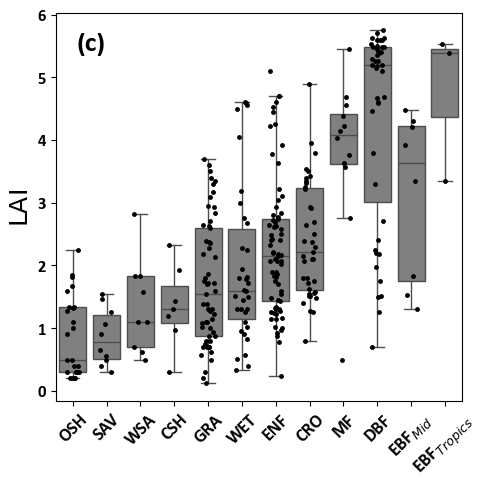

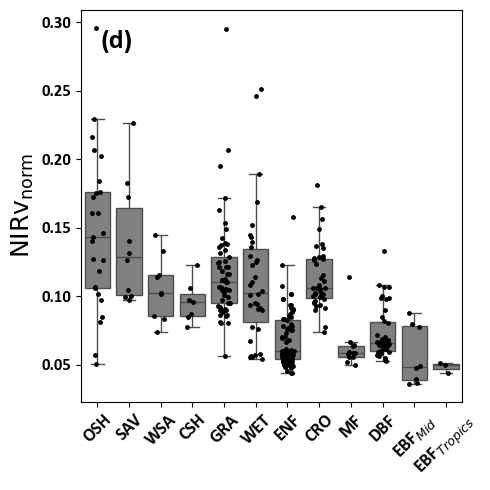

In [10]:
fig_lai, ax_lai = visualization.plot_biome_boxplot(
    data=site_annual_max_lue,
    y_variable="lue",
    y_label=r"$\epsilon_{\mathrm{Biome}}\ [\mu\mathrm{mol}\ \mathrm{CO}_2\ \mu\mathrm{mol}^{-1}\ \mathrm{Photon}]$",
    figure_label="(a)",
    output_path="../outputs/Figure_2a.png",
)
fig_NIRv, ax_NIRv = visualization.plot_biome_boxplot(
    data=site_annual_max_lue,
    y_variable="nirv",
    y_label=r"$\mathrm{NIRv}$",
    figure_label="(b)",
    output_path="../outputs/Figure_2b.png",
)
fig_LAI, ax_LAI = visualization.plot_biome_boxplot(
    data=site_annual_max_lue,
    y_variable="glass_lai",
    y_label=r"$\mathrm{LAI}$",
    figure_label="(c)",
    output_path="../outputs/Figure_2c.png",
)
fig_NIRvN, ax_NIRvN = visualization.plot_biome_boxplot(
    data=site_annual_max_lue,
    y_variable="norm_nirv_glass",
    y_label=r"$\mathrm{NIRv}_{\mathrm{norm}}$",
    figure_label="(d)",
    output_path="../outputs/Figure_2d.png",
)

## **Figure 3a: maximum biome LUE and NIRv**


Fitted parameters (All): a = 0.561 ± 0.162, h = 17.332 ± 2.951
Fitted parameters (excluding CRO): a = 0.688 ± 0.225, h = 20.374 ± 3.137


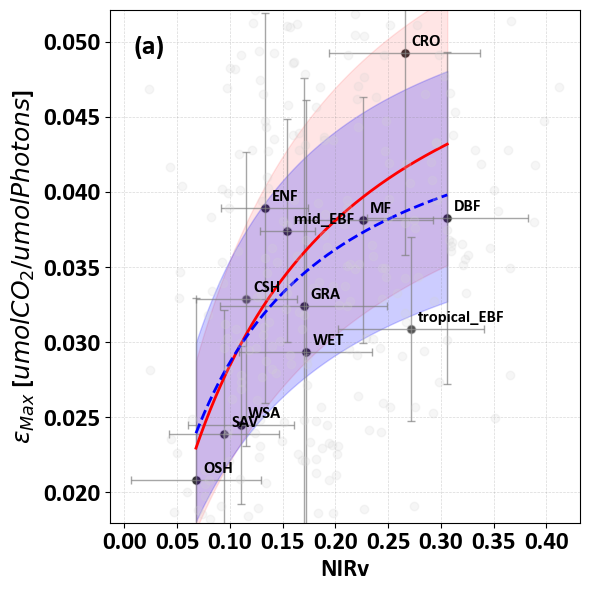

In [11]:
# Fit model between NIRv and LUE
a_fit_all, h_fit_all, a_error_all, h_error_all = utils.perform_analysis(
    nirv, lue, nirv_std, lue_std, num_measurements
)

# Perform analysis for data excluding crop
a_fit_no_crop, h_fit_no_crop, a_error_no_crop, h_error_no_crop = utils.perform_analysis(
    nirv_no_CRO, lue_no_cro, nirv_std_no_CRO, lue_std_no_cro, num_measurements_no_cro
)
fig_lue_nirv, ax_lue_nirv = visualization.plot_holling_relationship(
    x=nirv,
    y=lue,
    x_std=nirv_std,
    y_std=lue_std,
    types=types,
    a_fit_all=a_fit_all,
    h_fit_all=h_fit_all,
    a_error_all=a_error_all,
    h_error_all=h_error_all,
    a_fit_no_crop=a_fit_no_crop,
    h_fit_no_crop=h_fit_no_crop,
    a_error_no_crop=a_error_no_crop,
    h_error_no_crop=h_error_no_crop,
    background_data=site_annual_max_lue,
    x_key="nirv",
    y_key="lue",
    output_path="../outputs/Figure3_a.png",
    utils=utils,
    x_label="NIRv",
    y_label=r"$\epsilon_{Max}$ [$umolCO_{2} / umolPhotons$]",
    figure_label="(a)",
)

## **Figure 3b: maximum biome LUE and LAI**


Fitted parameters (All): a = 0.083 ± 0.037, h = 20.575 ± 2.675
Fitted parameters (excluding CRO): a = 0.083 ± 0.020, h = 22.225 ± 1.521


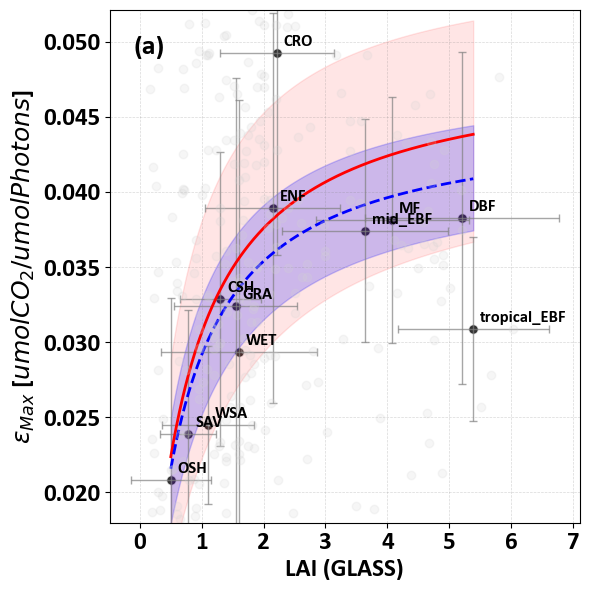

In [12]:
# Perform analysis for all data
a_fit_all, h_fit_all, a_error_all, h_error_all = utils.perform_analysis(
    glass_lai, lue, glass_lai_std, lue_std, num_measurements
)

# Perform analysis for data excluding crop
a_fit_no_crop, h_fit_no_crop, a_error_no_crop, h_error_no_crop = utils.perform_analysis(
    glass_lai_no_cro,
    lue_no_cro,
    glass_lai_std_no_cro,
    lue_std_no_cro,
    num_measurements_no_cro,
)

fig_lue_lai, ax_lue_lai = visualization.plot_holling_relationship(
    x=glass_lai,
    y=lue,
    x_std=glass_lai_std,
    y_std=lue_std,
    types=types,
    a_fit_all=a_fit_all,
    h_fit_all=h_fit_all,
    a_error_all=a_error_all,
    h_error_all=h_error_all,
    a_fit_no_crop=a_fit_no_crop,
    h_fit_no_crop=h_fit_no_crop,
    a_error_no_crop=a_error_no_crop,
    h_error_no_crop=h_error_no_crop,
    background_data=site_annual_max_lue,
    x_key="lai",
    y_key="lue",
    output_path="../outputs/Figure3_b.png",
    utils=utils,
    x_label="LAI (GLASS)",
    y_label=r"$\epsilon_{Max}$ [$umolCO_{2} / umolPhotons$]",
    figure_label="(a)",
)


## **Figure 3c: maximum biome LUE and NIRvN**


Results for All Data:
LUE = 0.0448 -0.0905 * NIRvN
R-squared: 0.0198
Adjusted R-squared: 0.0294
AIC: -76.4668
BIC: -75.4970

Results for Data Excluding Crop:
LUE = 0.0499 -0.1860 * NIRvN
R-squared: 0.5748
Adjusted R-squared: 0.8429
AIC: -95.6470
BIC: -94.8512


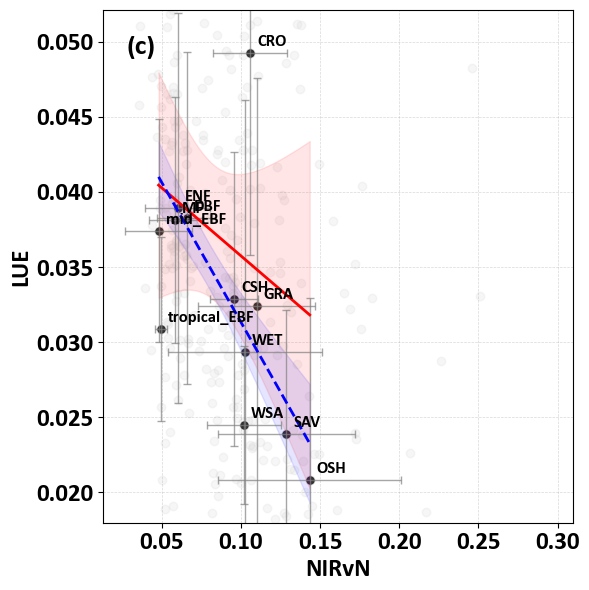

In [13]:
# Perform regression for all data
results_all = utils.perform_linear_regression(
    norm_nirv_glass, lue, norm_nirv_glass_std, lue_std, num_measurements
)

# Perform regression for data excluding crop
results_no_crop = utils.perform_linear_regression(
    norm_nirv_glass_no_cro,
    lue_no_cro,
    norm_nirv_glass_std_no_cro,
    lue_std_no_cro,
    num_measurements_no_cro,
)


# Plot the regression comparison
fig, ax = visualization.plot_regression_comparison(
    x_all=norm_nirv_glass,
    y_all=lue,
    x_std_all=norm_nirv_glass_std,
    y_std_all=lue_std,
    types=types,
    x_no_crop=norm_nirv_glass_no_cro,
    y_no_crop=lue_no_cro,
    x_std_no_crop=norm_nirv_glass_std_no_cro,
    y_std_no_crop=lue_std_no_cro,
    results_all=results_all,
    results_no_crop=results_no_crop,
    site_annual_max_data={
        "x": site_annual_max_lue["norm_nirv_glass"],
        "y": site_annual_max_lue["lue"],
    },
    x_label="NIRvN",
    y_label="LUE",
    output_path="../outputs/Figure3c.png",
    figure_label="(c)",
)


## **Figure 4a:NIRv vs LAI**


Results for All Data:
NIRV = 0.0901 +0.0411 * LAI
R-squared: 0.6386
Adjusted R-squared: 0.4996
AIC: -30.7995
BIC: -29.8297

Results for Data Excluding Crop:
NIRV = 0.0740 +0.0407 * LAI
R-squared: 0.8292
Adjusted R-squared: 0.7532
AIC: -38.0249
BIC: -37.2291


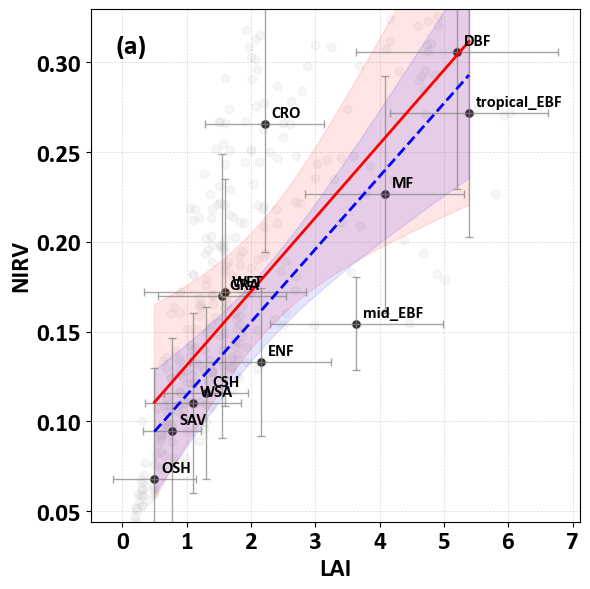

In [14]:
# Perform regression for all data
results_all = utils.perform_linear_regression(
    x=glass_lai,
    y=nirv,
    x_std=glass_lai_std,
    y_std=nirv_std,
    num_measurements=num_measurements,
)

# Perform regression for data excluding crop
results_no_crop = utils.perform_linear_regression(
    x=glass_lai_no_cro,
    y=nirv_no_CRO,
    x_std=glass_lai_std_no_cro,
    y_std=nirv_std_no_CRO,
    num_measurements=num_measurements_no_cro,
)

# Create the regression comparison plot
fig, ax = visualization.plot_regression_comparison(
    x_all=glass_lai,
    y_all=nirv,
    x_std_all=glass_lai_std,
    y_std_all=nirv_std,
    types=types,
    x_no_crop=glass_lai_no_cro,
    y_no_crop=nirv_no_CRO,
    x_std_no_crop=glass_lai_std_no_cro,
    y_std_no_crop=nirv_std_no_CRO,
    results_all=results_all,
    results_no_crop=results_no_crop,
    site_annual_max_data={
        "x": site_annual_max_lue["lai"],
        "y": site_annual_max_lue["nirv"],
    },
    x_label="LAI",
    y_label="NIRV",
    output_path="../outputs/Figure4a.png",
    figure_label="(a)",
)

## **Figure 4b NIRvN vs NIRv**


Results for All Data:
NIRv = 0.2418 -0.6186 * NIRvN
R-squared: 0.1947
Adjusted R-squared: -0.0444
AIC: -20.8561
BIC: -19.8863

Results for Data Excluding Crop:
NIRv = 0.2596 -1.0705 * NIRvN
R-squared: 0.4238
Adjusted R-squared: 0.1021
AIC: -22.0254
BIC: -21.2296


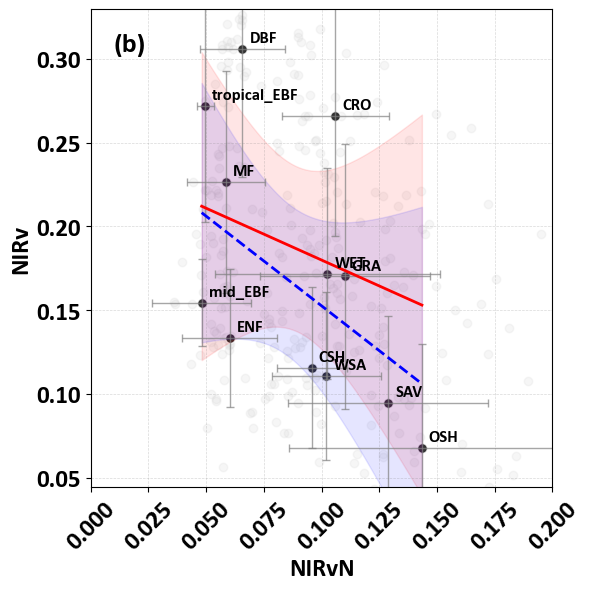

In [15]:
# Perform regression for all data
results_all = utils.perform_linear_regression(
    x=norm_nirv_glass,
    y=nirv,
    x_std=norm_nirv_glass_std,
    y_std=nirv_std,
    num_measurements=num_measurements,
)
results_no_crop = utils.perform_linear_regression(
    x=norm_nirv_glass_no_cro,
    y=nirv_no_CRO,
    x_std=norm_nirv_glass_std_no_cro,
    y_std=nirv_std_no_CRO,
    num_measurements=num_measurements_no_cro,
)

fig, ax = visualization.plot_regression_comparison(
    x_all=norm_nirv_glass,
    y_all=nirv,
    x_std_all=norm_nirv_glass_std,
    y_std_all=nirv_std,
    types=types,
    x_no_crop=norm_nirv_glass_no_cro,
    y_no_crop=nirv_no_CRO,
    x_std_no_crop=norm_nirv_glass_std_no_cro,
    y_std_no_crop=nirv_std_no_CRO,
    results_all=results_all,
    results_no_crop=results_no_crop,
    site_annual_max_data=site_annual_max_lue,
    x_key="norm_nirv_glass",
    y_key="nirv",
    x_label="NIRvN",
    y_label="NIRv",
    output_path="../outputs/Figure4b.png",
    figure_label="(b)",
    x_lim=(0, 0.2),
    rotate_x_labels=True,
)

# **Supplimentary figures**


## \*\* Figure S1 boxplot of MODIS LAI


/home/hamid/dscovr/EL_LUE_Codes/src/visualization.py:663: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


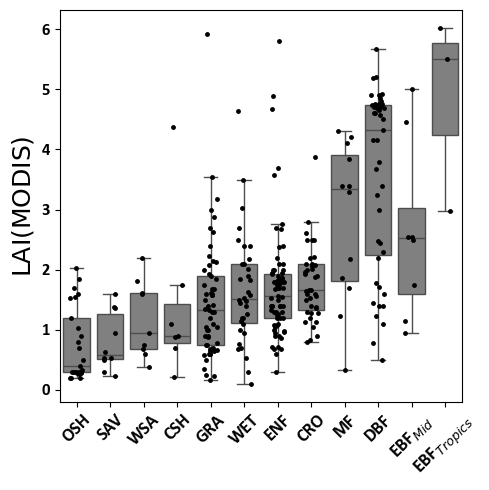

In [16]:
fig_LAI, ax_LAI = visualization.plot_biome_boxplot(
    data=site_annual_max_lue,
    y_variable="lai",
    y_label=r"$\mathrm{LAI (MODIS)}$",
    figure_label="",
    output_path="../outputs/Figure_S1.png",
)

## **Figure S2a: maximum LUE vs MODIS LAI**


Fitted parameters (All): a = 0.121 ± 0.055, h = 21.952 ± 2.477
Fitted parameters (excluding CRO): a = 0.119 ± 0.036, h = 23.042 ± 1.684


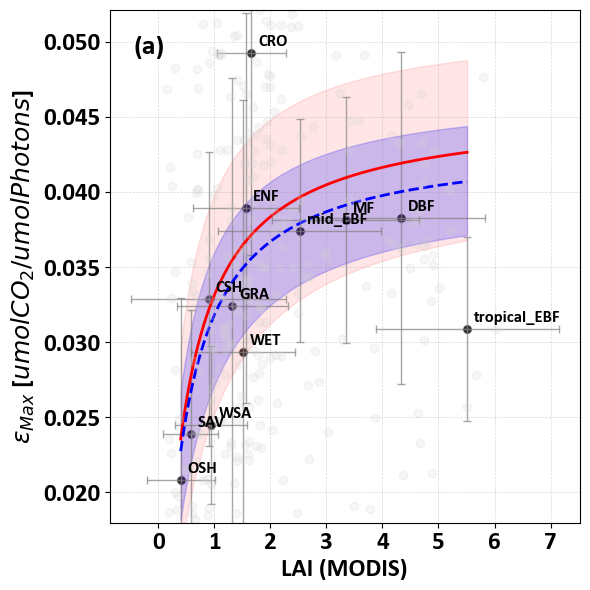

In [17]:
# Perform analysis for all data
a_fit_all, h_fit_all, a_error_all, h_error_all = utils.perform_analysis(
    modis_lai, lue, modis_lai_std, lue_std, num_measurements
)

# Perform analysis for data excluding crop
a_fit_no_crop, h_fit_no_crop, a_error_no_crop, h_error_no_crop = utils.perform_analysis(
    modis_lai_no_cro,
    lue_no_cro,
    modis_lai_std_no_cro,
    lue_std_no_cro,
    num_measurements_no_cro,
)


fig_lue_lai, ax_lue_lai = visualization.plot_holling_relationship(
    x=modis_lai,
    y=lue,
    x_std=modis_lai_std,
    y_std=lue_std,
    types=types,
    a_fit_all=a_fit_all,
    h_fit_all=h_fit_all,
    a_error_all=a_error_all,
    h_error_all=h_error_all,
    a_fit_no_crop=a_fit_no_crop,
    h_fit_no_crop=h_fit_no_crop,
    a_error_no_crop=a_error_no_crop,
    h_error_no_crop=h_error_no_crop,
    background_data=site_annual_max_lue,
    x_key="lai",
    y_key="lue",
    output_path="../outputs/FigureS2_a.png",
    utils=utils,
    x_label="LAI (MODIS)",
    y_label=r"$\epsilon_{Max}$ [$umolCO_{2} / umolPhotons$]",
    figure_label="(a)",
)


## **Figure S2b: NIRv vs MODIS LAI**


Results for All Data:
NIRV = 0.0876 +0.0501 * LAI (MODIS)
R-squared: 0.5987
Adjusted R-squared: 0.6115
AIC: -34.2996
BIC: -33.3298

Results for Data Excluding Crop:
NIRV = 0.0747 +0.0509 * LAI (MODIS)
R-squared: 0.7786
Adjusted R-squared: 0.8414
AIC: -42.0469
BIC: -41.2511


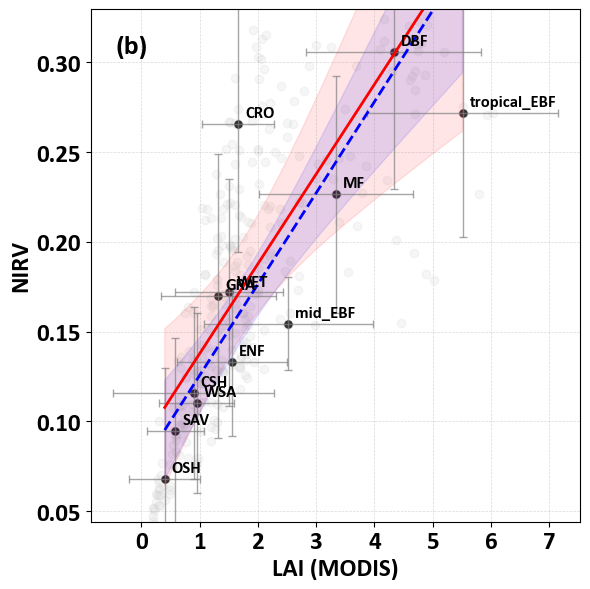

In [18]:
# Perform regression for all data
results_all = utils.perform_linear_regression(
    x=modis_lai,
    y=nirv,
    x_std=modis_lai_std,
    y_std=nirv_std,
    num_measurements=num_measurements,
)

# Perform regression for data excluding crop
results_no_crop = utils.perform_linear_regression(
    x=modis_lai_no_cro,
    y=nirv_no_CRO,
    x_std=modis_lai_std_no_cro,
    y_std=nirv_std_no_CRO,
    num_measurements=num_measurements_no_cro,
)

# Create the regression comparison plot
fig, ax = visualization.plot_regression_comparison(
    x_all=modis_lai,
    y_all=nirv,
    x_std_all=modis_lai_std,
    y_std_all=nirv_std,
    types=types,
    x_no_crop=modis_lai_no_cro,
    y_no_crop=nirv_no_CRO,
    x_std_no_crop=modis_lai_std_no_cro,
    y_std_no_crop=nirv_std_no_CRO,
    results_all=results_all,
    results_no_crop=results_no_crop,
    site_annual_max_data={
        "x": site_annual_max_lue["lai"],
        "y": site_annual_max_lue["nirv"],
    },
    x_label="LAI (MODIS)",
    y_label="NIRV",
    output_path="../outputs/FigureS2b.png",
    figure_label="(b)",
)


## **Figure S3: Relationship between LUE and NIRv and LAI**


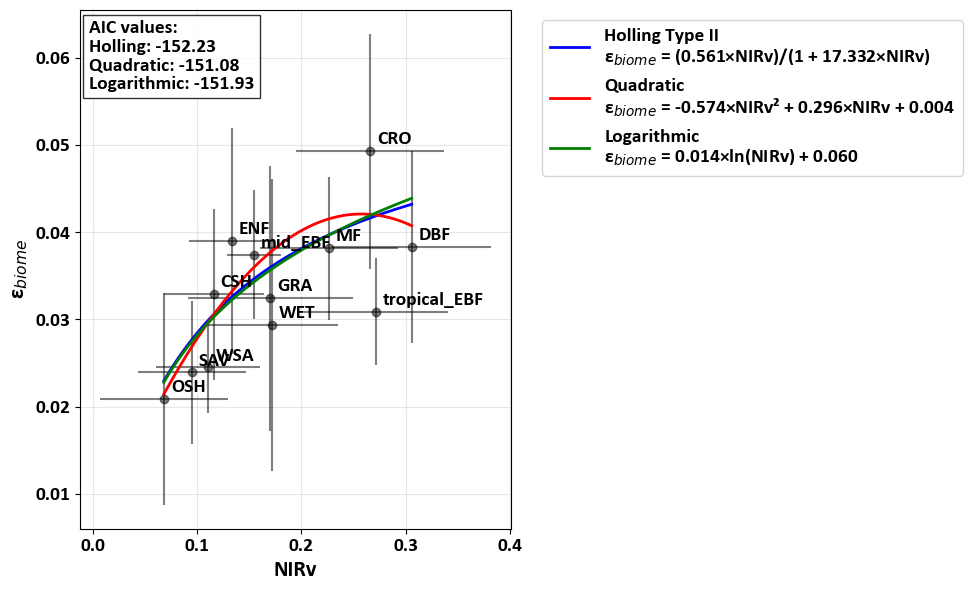

In [19]:
results = utils.fit_all_models(nirv, lue, nirv_std, lue_std, num_measurements)
outname = "../outputs/FigureS3_a.png"
# Use the function with your data

visualization.plot_models_fits(nirv, lue, results, nirv_std, lue_std, types, outname)

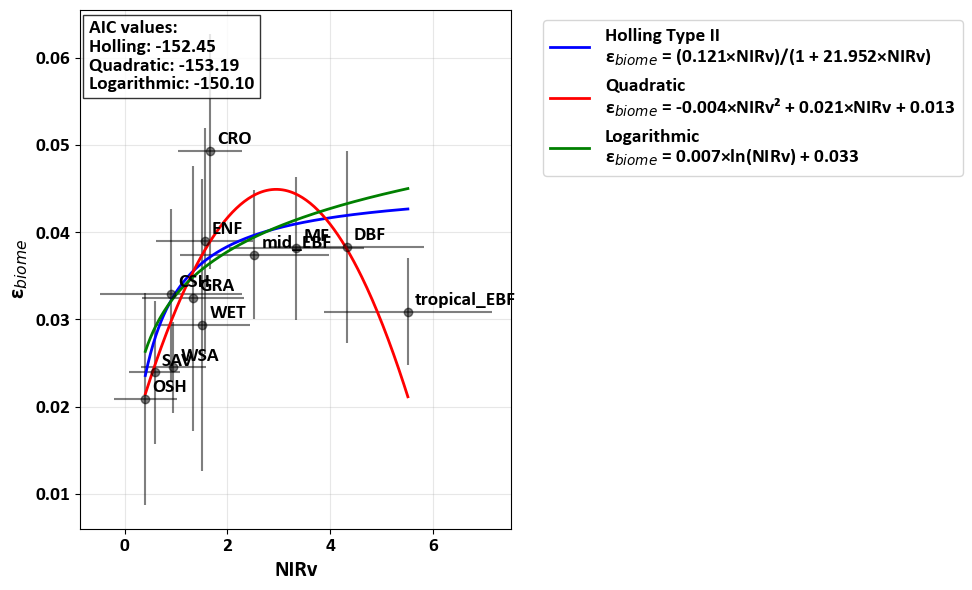

In [20]:
results = utils.fit_all_models(modis_lai, lue, modis_lai_std, lue_std, num_measurements)
outname = "../outputs/FigureS3_b.png"
visualization.plot_models_fits(
    modis_lai, lue, results, modis_lai_std, lue_std, types, outname
)

## **Figure S4: Inidividual biones**


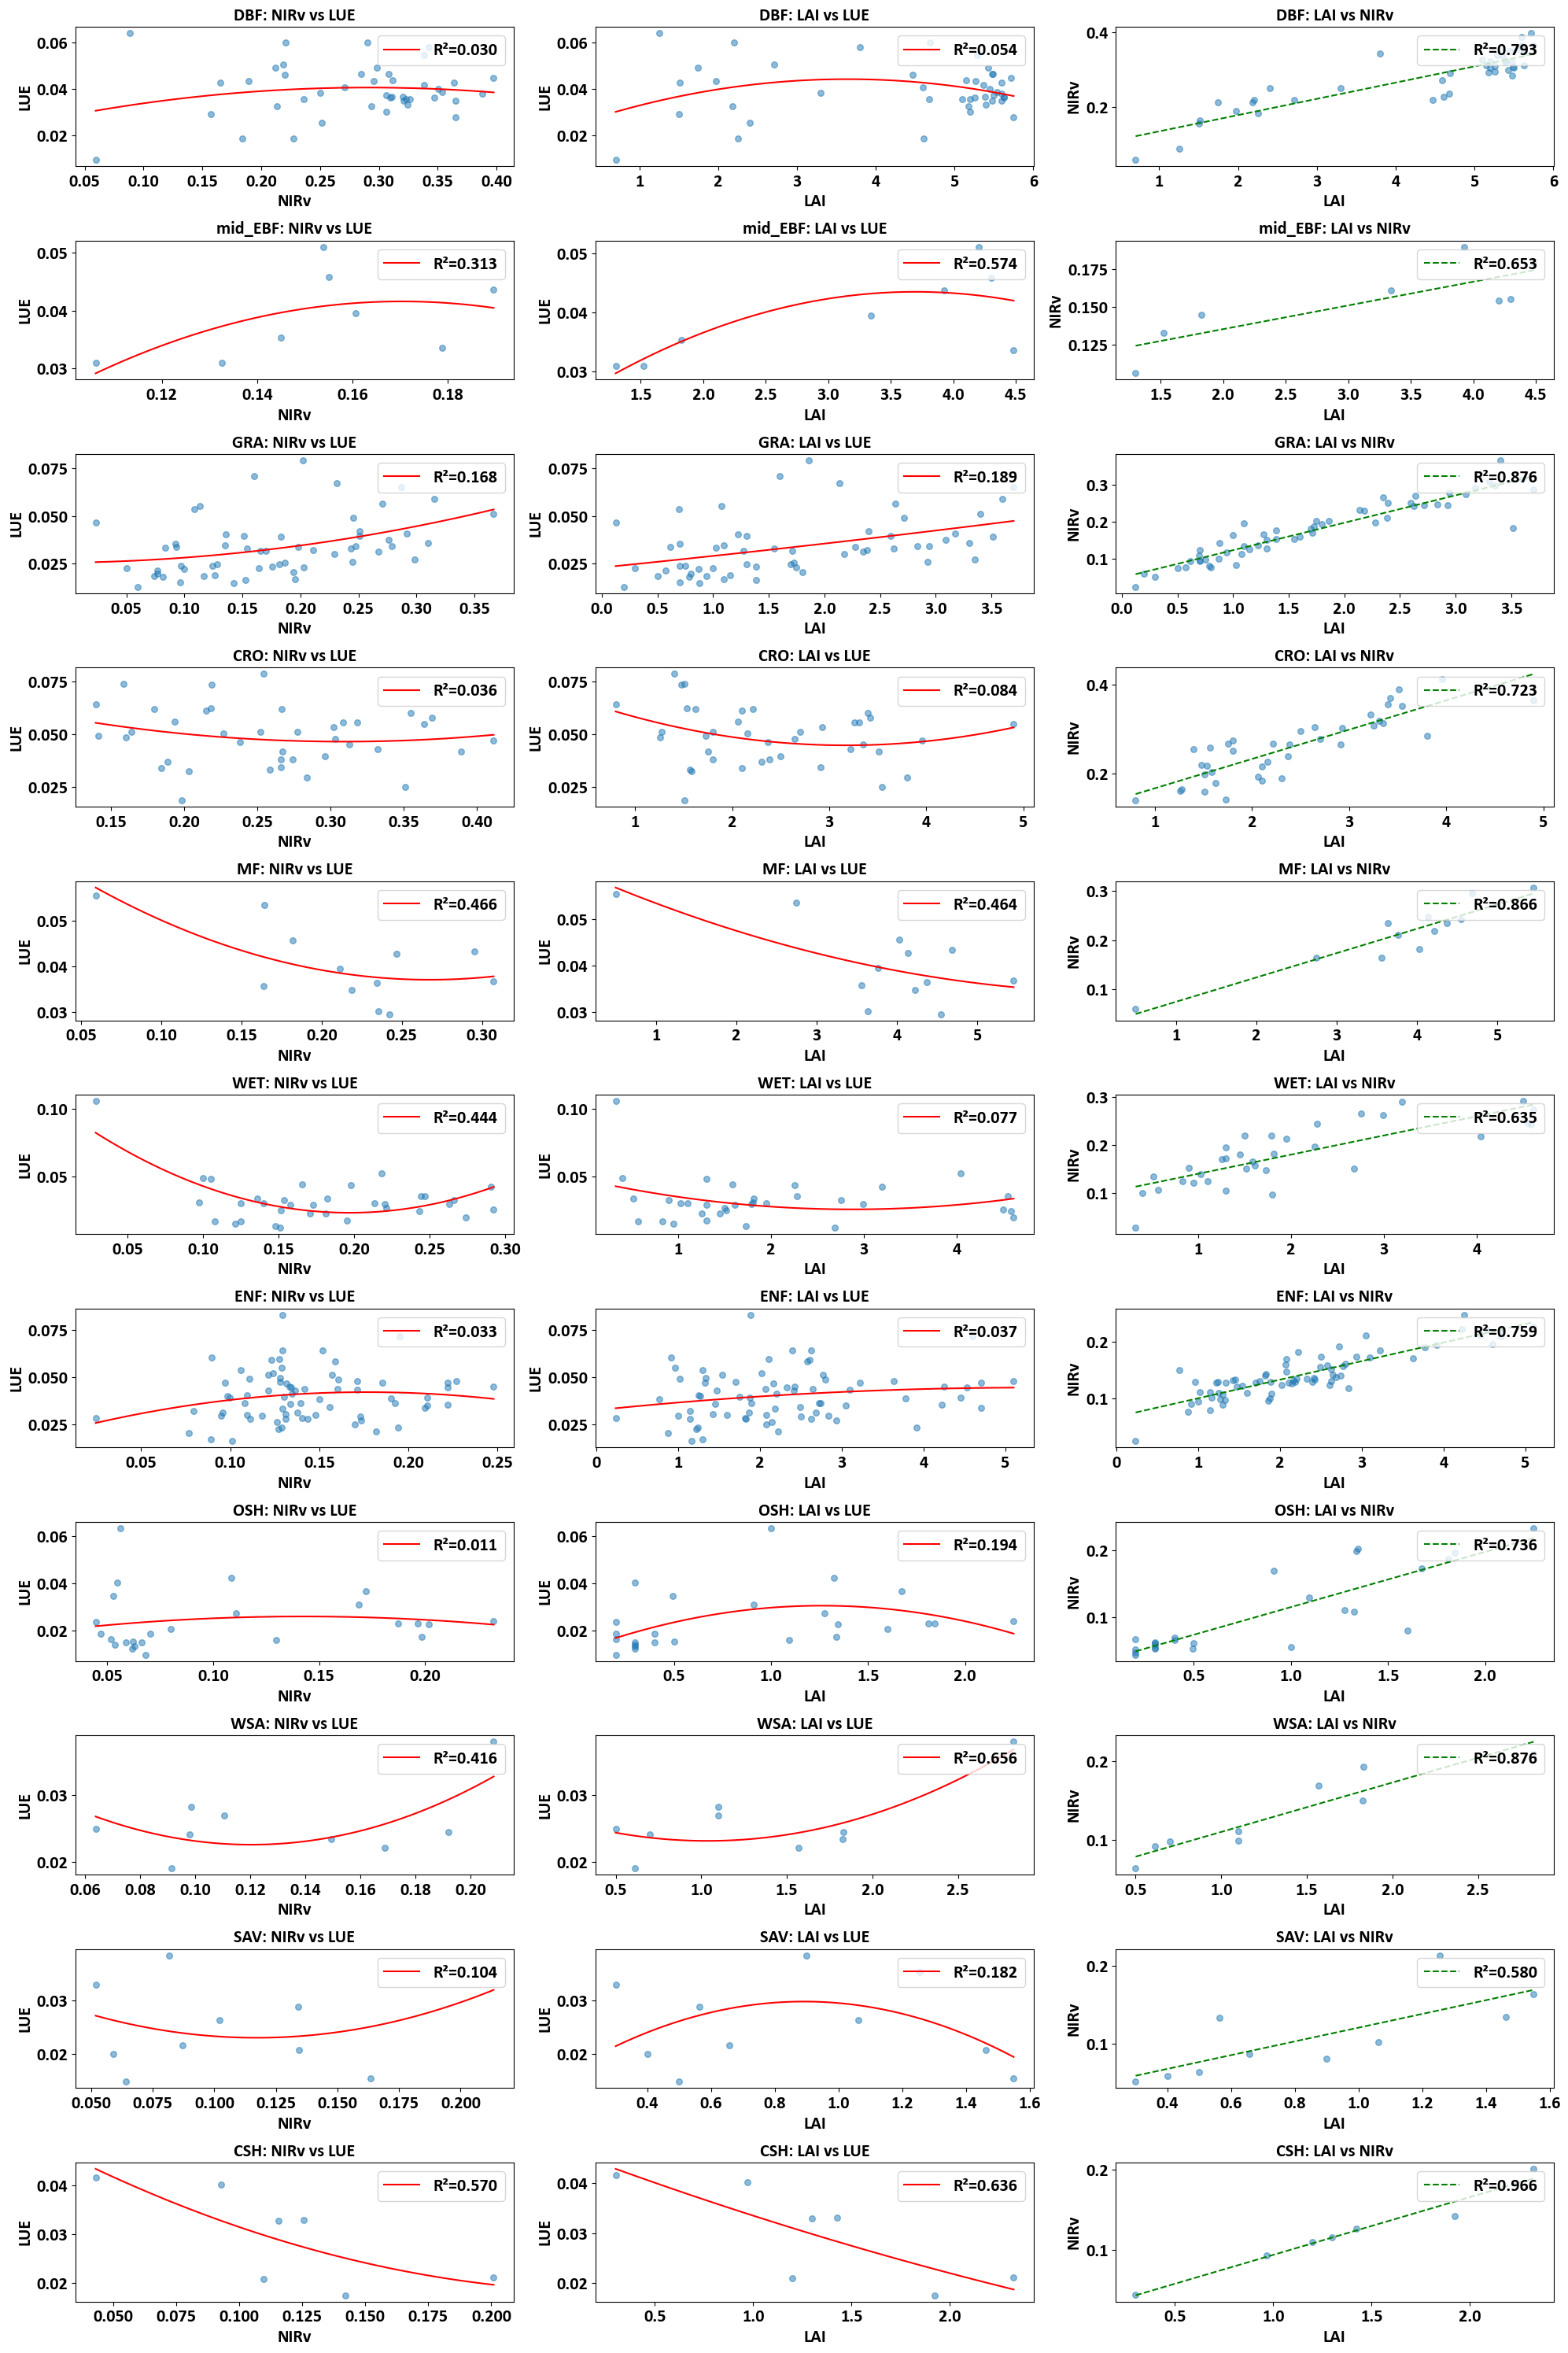

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

# Set up font properties
font = FontProperties()
font.set_weight("bold")
font.set_size(16)

# Create a large figure
plt.figure(figsize=(20, 30))

# Get unique types
types = site_annual_max_lue["new_type"].unique()
types = types[
    types != "tropical_EBF"
]  # Remove tropical EBF as it has only three data point

# Loop through each type
for i, type_name in enumerate(types):
    type_data = site_annual_max_lue[site_annual_max_lue["new_type"] == type_name]

    # Extract data
    lue = type_data["lue"].values
    nirv = type_data["nirv"].values
    lai = type_data["glass_lai"].values

    # First subplot: NIRV vs LUE (Quadratic only)
    ax = plt.subplot(11, 3, 3 * i + 1)
    coeffs_quad, r2_quad, p_quad, quad_func, coeffs_lin, r2_lin, p_lin, linear_func = (
        utils.fit_biome_models(nirv, lue)
    )

    x_smooth = np.linspace(min(nirv), max(nirv), 100)
    plt.scatter(nirv, lue, alpha=0.5, s=30)
    plt.plot(x_smooth, quad_func(x_smooth), "r-", label=f"R²={r2_quad:.3f}")
    plt.xlabel("NIRv", fontproperties=font)
    plt.ylabel("LUE", fontproperties=font)
    plt.title(f"{type_name}: NIRv vs LUE", fontproperties=font)
    plt.legend(fontsize=16, loc="upper right")
    ax.tick_params(axis="both", which="major", labelsize=16)

    # Second subplot: LAI vs LUE (Quadratic only)
    ax = plt.subplot(11, 3, 3 * i + 2)
    coeffs_quad, r2_quad, p_quad, quad_func, coeffs_lin, r2_lin, p_lin, linear_func = (
        utils.fit_biome_models(lai, lue)
    )

    x_smooth = np.linspace(min(lai), max(lai), 100)
    plt.scatter(lai, lue, alpha=0.5, s=30)
    plt.plot(x_smooth, quad_func(x_smooth), "r-", label=f"R²={r2_quad:.3f}")
    plt.xlabel("LAI", fontproperties=font)
    plt.ylabel("LUE", fontproperties=font)
    plt.title(f"{type_name}: LAI vs LUE", fontproperties=font)
    plt.legend(fontsize=16, loc="upper right")
    ax.tick_params(axis="both", which="major", labelsize=16)

    # Third subplot: LAI vs NIRV (Linear only)
    ax = plt.subplot(11, 3, 3 * i + 3)
    coeffs_quad, r2_quad, p_quad, quad_func, coeffs_lin, r2_lin, p_lin, linear_func = (
        utils.fit_biome_models(lai, nirv)
    )

    x_smooth = np.linspace(min(lai), max(lai), 100)
    plt.scatter(lai, nirv, alpha=0.5, s=30)
    plt.plot(x_smooth, linear_func(x_smooth), "g--", label=f"R²={r2_lin:.3f}")
    plt.xlabel("LAI", fontproperties=font)
    plt.ylabel("NIRv", fontproperties=font)
    plt.title(f"{type_name}: LAI vs NIRv", fontproperties=font)
    plt.legend(fontsize=16, loc="upper right")
    ax.tick_params(axis="both", which="major", labelsize=16)

plt.tight_layout()
plt.savefig("../outputs/FigureS4.png", dpi=300, bbox_inches="tight")
plt.show()

## **Table S1: median and standard deviation of LUE, NIRv, LAI for each biome**


In [22]:
table = biome_LUEMax_median.copy()
for column in biome_LUEMax_median.columns:
    table[column] = biome_LUEMax_median[column].combine(
        biome_LUEMax_se[column], func=utils.format_mean_se
    )
# table.to_csv("../outputs/mean_se_table.csv")
print("Statistics of biome LUE max:\n")
table


Statistics of biome LUE max:



,fpar,nirv,nirvp,lue,lai,glass_lai,apar,norm_nirv_glass,norm_nirv_modis
type,,,,,,,,,
CRO,0.6300 ± 0.0161,0.2658 ± 0.0114,108.0225 ± 7.5235,0.0493 ± 0.0022,1.6625 ± 0.0988,2.2125 ± 0.1478,267.3553 ± 16.4384,0.1059 ± 0.0037,0.1512 ± 0.0041
CSH,0.3925 ± 0.0893,0.1157 ± 0.0182,38.6992 ± 4.5878,0.0329 ± 0.0037,0.9000 ± 0.5229,1.3000 ± 0.2469,137.1875 ± 19.4021,0.0957 ± 0.0057,0.1302 ± 0.0163
DBF,0.8402 ± 0.0244,0.3060 ± 0.0117,72.3497 ± 4.2200,0.0383 ± 0.0017,4.3281 ± 0.2294,5.2000 ± 0.2391,207.0067 ± 8.9222,0.0657 ± 0.0028,0.0783 ± 0.0050
ENF,0.6150 ± 0.0170,0.1332 ± 0.0048,26.3184 ± 1.5950,0.0390 ± 0.0015,1.5625 ± 0.1103,2.1500 ± 0.1278,107.7471 ± 5.7644,0.0602 ± 0.0024,0.0847 ± 0.0031
GRA,0.5400 ± 0.0245,0.1701 ± 0.0105,42.4951 ± 4.0301,0.0324 ± 0.0020,1.3250 ± 0.1311,1.5500 ± 0.1319,136.9215 ± 9.6472,0.1100 ± 0.0049,0.1356 ± 0.0044
MF,0.8000 ± 0.0495,0.2266 ± 0.0191,43.5796 ± 4.7909,0.0381 ± 0.0024,3.3438 ± 0.3802,4.0813 ± 0.3570,137.7745 ± 11.6688,0.0587 ± 0.0049,0.0779 ± 0.0099
OSH,0.2629 ± 0.0436,0.0679 ± 0.0123,26.3774 ± 2.2112,0.0208 ± 0.0024,0.4031 ± 0.1219,0.5000 ± 0.1287,83.2477 ± 8.0863,0.1435 ± 0.0115,0.1696 ± 0.0101
SAV,0.3271 ± 0.0458,0.0946 ± 0.0164,42.1417 ± 8.0437,0.0239 ± 0.0026,0.5828 ± 0.1547,0.7781 ± 0.1423,143.7356 ± 21.5652,0.1288 ± 0.0137,0.1515 ± 0.0129
WET,0.6169 ± 0.0279,0.1718 ± 0.0108,39.7137 ± 4.8739,0.0293 ± 0.0029,1.5125 ± 0.1590,1.5969 ± 0.2161,132.7478 ± 13.5381,0.1026 ± 0.0084,0.1162 ± 0.0078


In [23]:
print("Script finished successfully.")

Script finished successfully.


# **End of the script**
